#Estimating Morocco's regions COVID-19 $R_t$ in Real-Time

#### DijkstraFTW - July - 2022

###$R_t$ : A brief introduction

The effective reproduction number $R_t$ is defined as the average number of secondary infections produced by an infected case in a population where some individuals are no longer susceptible to infection. For example, an $R_t$ of 2 implies that an infected person will transmit COVID-19 to two people on average during the time they are infectious. 

Taking into account the incubation period of the virus and other delays, the estimated $R_t$ represents the level of transmission observed almost 10 days ago.

A simplified interpretation of this figure could be summarized as follows : 

*   $R_t$ > 1 indicates that transmission is increasing.
*   $R_t$ = 1 indicates that the transmission is stable.
*   $R_t$ < 1 indicates that the epidemic is under control.

###Morocco's regions and provinces

Regions are currently the highest administrative divisions in Morocco. Since 2015, Morocco officially administers 12 regions, instead of the 16 regions that composed it between 1997 and 2010. These regions are subdivided into a total of 75 administrative divisions, which are prefectures and provinces.

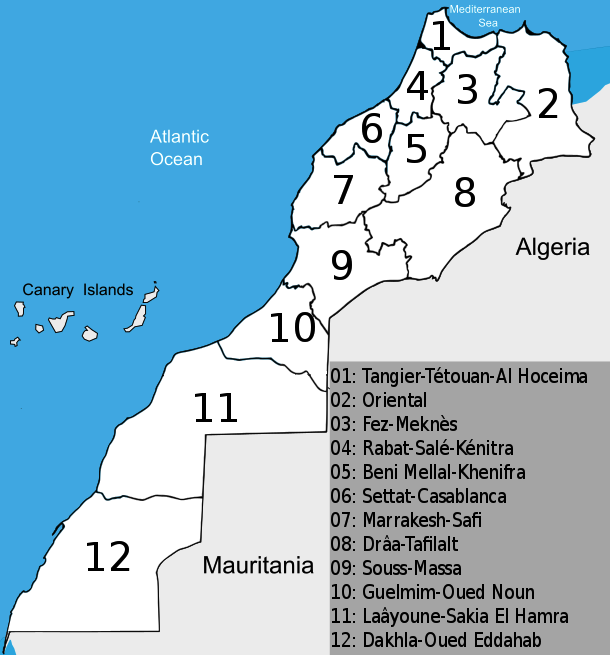



###Objective

We aim to apply the methodology applied by Kevin Systrom in the following [notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), which is partly based on [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) by Bettencourt & Ribeiro, exploring solutions to estimate the real-time $R_t$ using a Bayesian approach. 
I highly advise you to check them out to get a good understanding of the following content and the theory behind it.

We hope to get sensible enough results so as to gain a clearer and broader outlook on the evolution of COVID-19's $R_t$ and the pandemic's progress over time in Morocco.

As always, all credits to the initial authors, which were kind enough to publish their workavailable to the public.

In [1]:
#Imports

import requests
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from urllib.request import urlopen
from scipy.stats import poisson
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from urllib.request import urlopen
from scipy import stats as sps
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

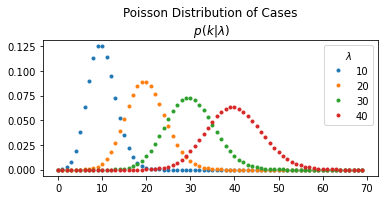

In [2]:
k = np.arange(0, 70)[:, None]

lambdas = [10, 20, 30, 40]
y = sps.poisson.pmf(k, lambdas)

fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

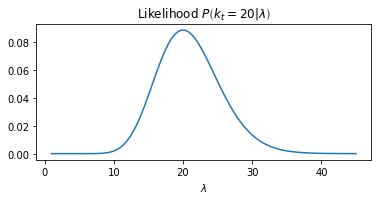

In [3]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5));

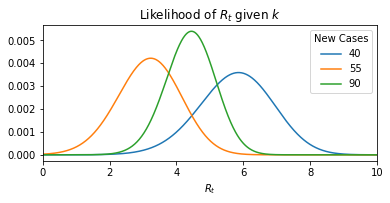

In [4]:
k = np.array([20, 40, 55, 90])

R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

GAMMA = 1/7

lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

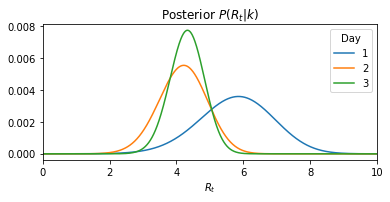

In [5]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [6]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [7]:
def highest_density_interval(pmf, p=.9, debug=False):
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    total_p = cumsum - cumsum[:, None]
    lows, highs = (total_p > p).nonzero()
    best = (highs - lows).argmin()
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


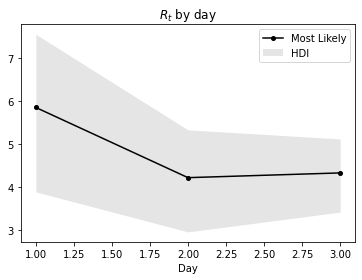

In [8]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

##Importing the Data

In [9]:
url = "https://api-mp.medias24.com/public/daily_new_cases"

r = requests.get(url)
regions = r.json()

##Adding the region's names

In [10]:
regions_list = [
    'Casablanca - Settat',
    'Rabat - Salé - Kénitra',
    'Tanger - Tétouan - Al Hoceima',
    'Souss - Massa',
    'Guelmim - Oued Noun',
    'Laâyoune - Sakia El Hamra',
    'Dakhla - Oued Eddahab',
    'Drâa - Tafilalet',
    'Marrakech - Safi',
    'Béni Mellal - Khénifra',
    'Fès - Meknès',
    "L'Oriental"
]
provinces_indexes = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14, 15, 16],
    [17, 18, 19, 20, 21, 22, 23, 24],
    [25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34],
    [35, 36, 37, 38],
    [39, 40],
    [41, 42, 43, 44, 45],
    [46, 47, 48, 49, 50, 51, 52, 53],
    [54, 55, 56, 57, 58],
    [59, 60, 61, 62, 63, 64, 65, 66],
    [67, 68, 69, 70, 71, 72, 73, 74, 75],
]

for index in range(len(regions["cases"])) :
  for i in range (len(provinces_indexes)) :
    for j in range (len(provinces_indexes[i])) :
      if (provinces_indexes[i][j] == regions["cases"][index]['id']) :
          regions["cases"][index]['region'] = regions_list[i]

In [11]:
df_cases = pd.DataFrame(regions["cases"])
df_cases

,id,province,cases,region
0,1,Casablanca,"[46, 20, 72, 68, 48, 20, 612, 80, 83, 40, 48, ...",Casablanca - Settat
1,2,Nouaceur,"[0, 0, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 4, 0, 16,...",Casablanca - Settat
2,3,Mohammédia,"[0, 0, 3, 3, 0, 18, 0, 2, 0, 1, 2, 28, 3, 2, 6...",Casablanca - Settat
3,4,Settat,"[0, 2, 0, 0, 0, 0, 0, 0, 3, 11, 0, 53, 55, 0, ...",Casablanca - Settat
4,5,Berrechid,"[1, 0, 1, 4, 0, 3, 0, 0, 120, 127, 168, 42, 24...",Casablanca - Settat
...,...,...,...,...
70,71,Oujda-Angad,"[13, 12, 11, 5, 2, 1, 4, 4, 0, 1, 0, 2, 6, 1, ...",L'Oriental
71,72,Jerada,"[1, 1, 5, 1, 0, 4, 0, 0, 21, 0, 9, 3, 0, 2, 16...",L'Oriental
72,73,Figuig,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",L'Oriental
73,74,Guercif,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",L'Oriental


##Date Formatting

In [12]:
df_dates = pd.DataFrame(regions['date'])
df_dates.rename( columns={0:'dates'}, inplace=True )
df_dates['dateFormatted'] = pd.to_datetime(df_dates['dates'], format="%Y-%m-%d")

dates = df_dates['dates'].values.tolist()
df_dates.head()

,dates,dateFormatted
0,2020-07-16,2020-07-16
1,2020-07-17,2020-07-17
2,2020-07-18,2020-07-18
3,2020-07-19,2020-07-19
4,2020-07-20,2020-07-20


In [13]:
reg_list = df_cases['region'].drop_duplicates().tolist()
reg_list

['Casablanca - Settat',
 'Rabat - Salé - Kénitra',
 'Tanger - Tétouan - Al Hoceima',
 'Souss - Massa',
 'Guelmim - Oued Noun',
 'Laâyoune - Sakia El Hamra',
 'Dakhla - Oued Eddahab',
 'Drâa - Tafilalet',
 'Marrakech - Safi',
 'Béni Mellal - Khénifra',
 'Fès - Meknès',
 "L'Oriental"]

In [14]:
reg_data = []

temp = [0] * (len((df_cases["cases"][0])))

for i in range (len(df_cases["cases"])) :
    
    if (i + 1 == 75) :
        reg_data.append(temp)
        break
    
    for j in range (len(df_cases["cases"][0])) :
        
        temp[j] += df_cases["cases"][i][j]
    
    if (df_cases["region"][i] != df_cases["region"][i + 1]):
            reg_data.append(temp)
            temp = [0] * (len((df_cases["cases"][0])))

df_regions_data = pd.DataFrame(reg_data, index = reg_list, columns=df_dates['dateFormatted'])
df_regions_data.T

,Casablanca - Settat,Rabat - Salé - Kénitra,Tanger - Tétouan - Al Hoceima,Souss - Massa,Guelmim - Oued Noun,Laâyoune - Sakia El Hamra,Dakhla - Oued Eddahab,Drâa - Tafilalet,Marrakech - Safi,Béni Mellal - Khénifra,Fès - Meknès,L'Oriental
dateFormatted,,,,,,,,,,,,
2020-07-16,51,9,86,0,1,1,6,0,44,0,71,14
2020-07-17,23,2,56,0,1,0,3,1,0,0,57,15
2020-07-18,76,6,92,0,3,0,6,0,9,1,75,21
2020-07-19,76,4,49,1,3,0,0,1,18,0,62,8
2020-07-20,48,5,181,0,1,3,3,0,15,2,64,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-08,0,9,1,1,0,0,0,0,0,0,0,0
2023-02-09,2,8,0,0,0,0,0,0,2,0,1,0
2023-02-10,3,1,0,0,0,0,0,0,0,0,1,0


##Plotting new daily cases + weekly average

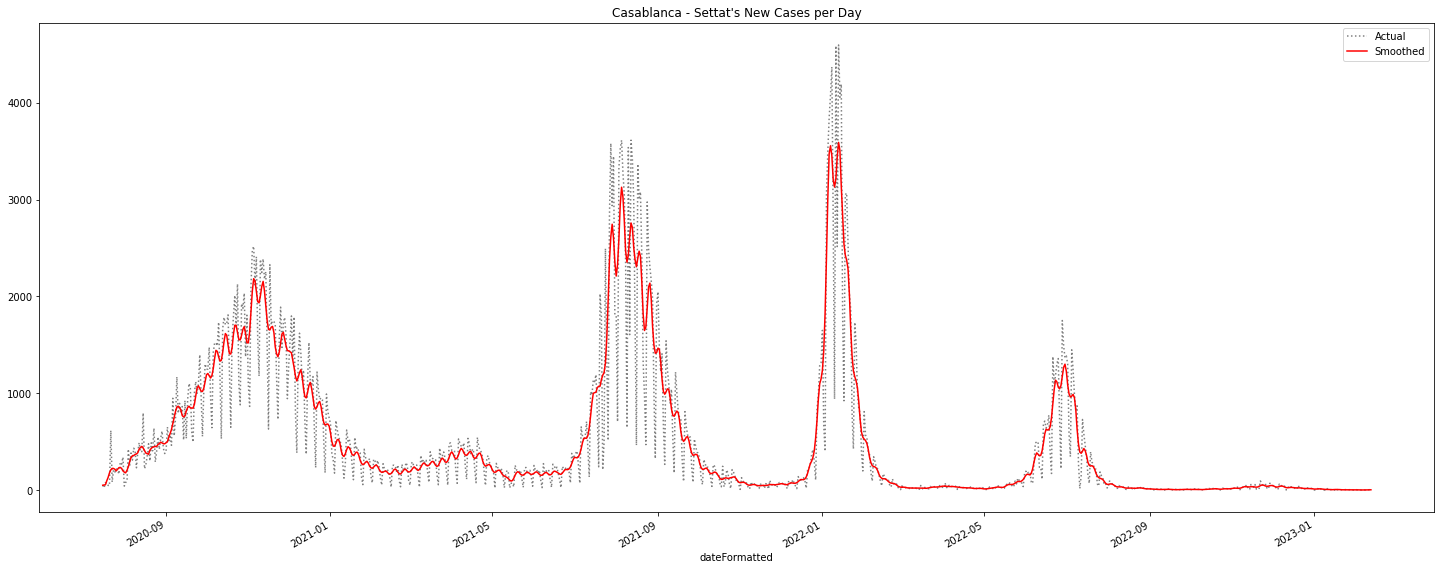

In [15]:
region = 0

state_name = reg_list[region]

def prepare_cases(cases, cutoff=0):
    new_cases = cases

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

reg_d = pd.DataFrame(reg_data[region])
reg_d = reg_d.squeeze()

reg_d_plus = pd.DataFrame(reg_data[region], df_dates['dateFormatted'])
reg_d_plus = reg_d_plus.squeeze()

cases = reg_d
cases_plus = reg_d_plus

original, smoothed = prepare_cases(cases, 25)

original_plus, smoothed_plus = prepare_cases(cases_plus)

ax = original_plus.plot(title=f"{state_name}'s New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(25, 10))

ax = smoothed_plus.plot(label='Smoothed', legend=True, color ='red')
ax.get_figure().set_facecolor('w')

##Plotting all regions's new daily cases + weekly average

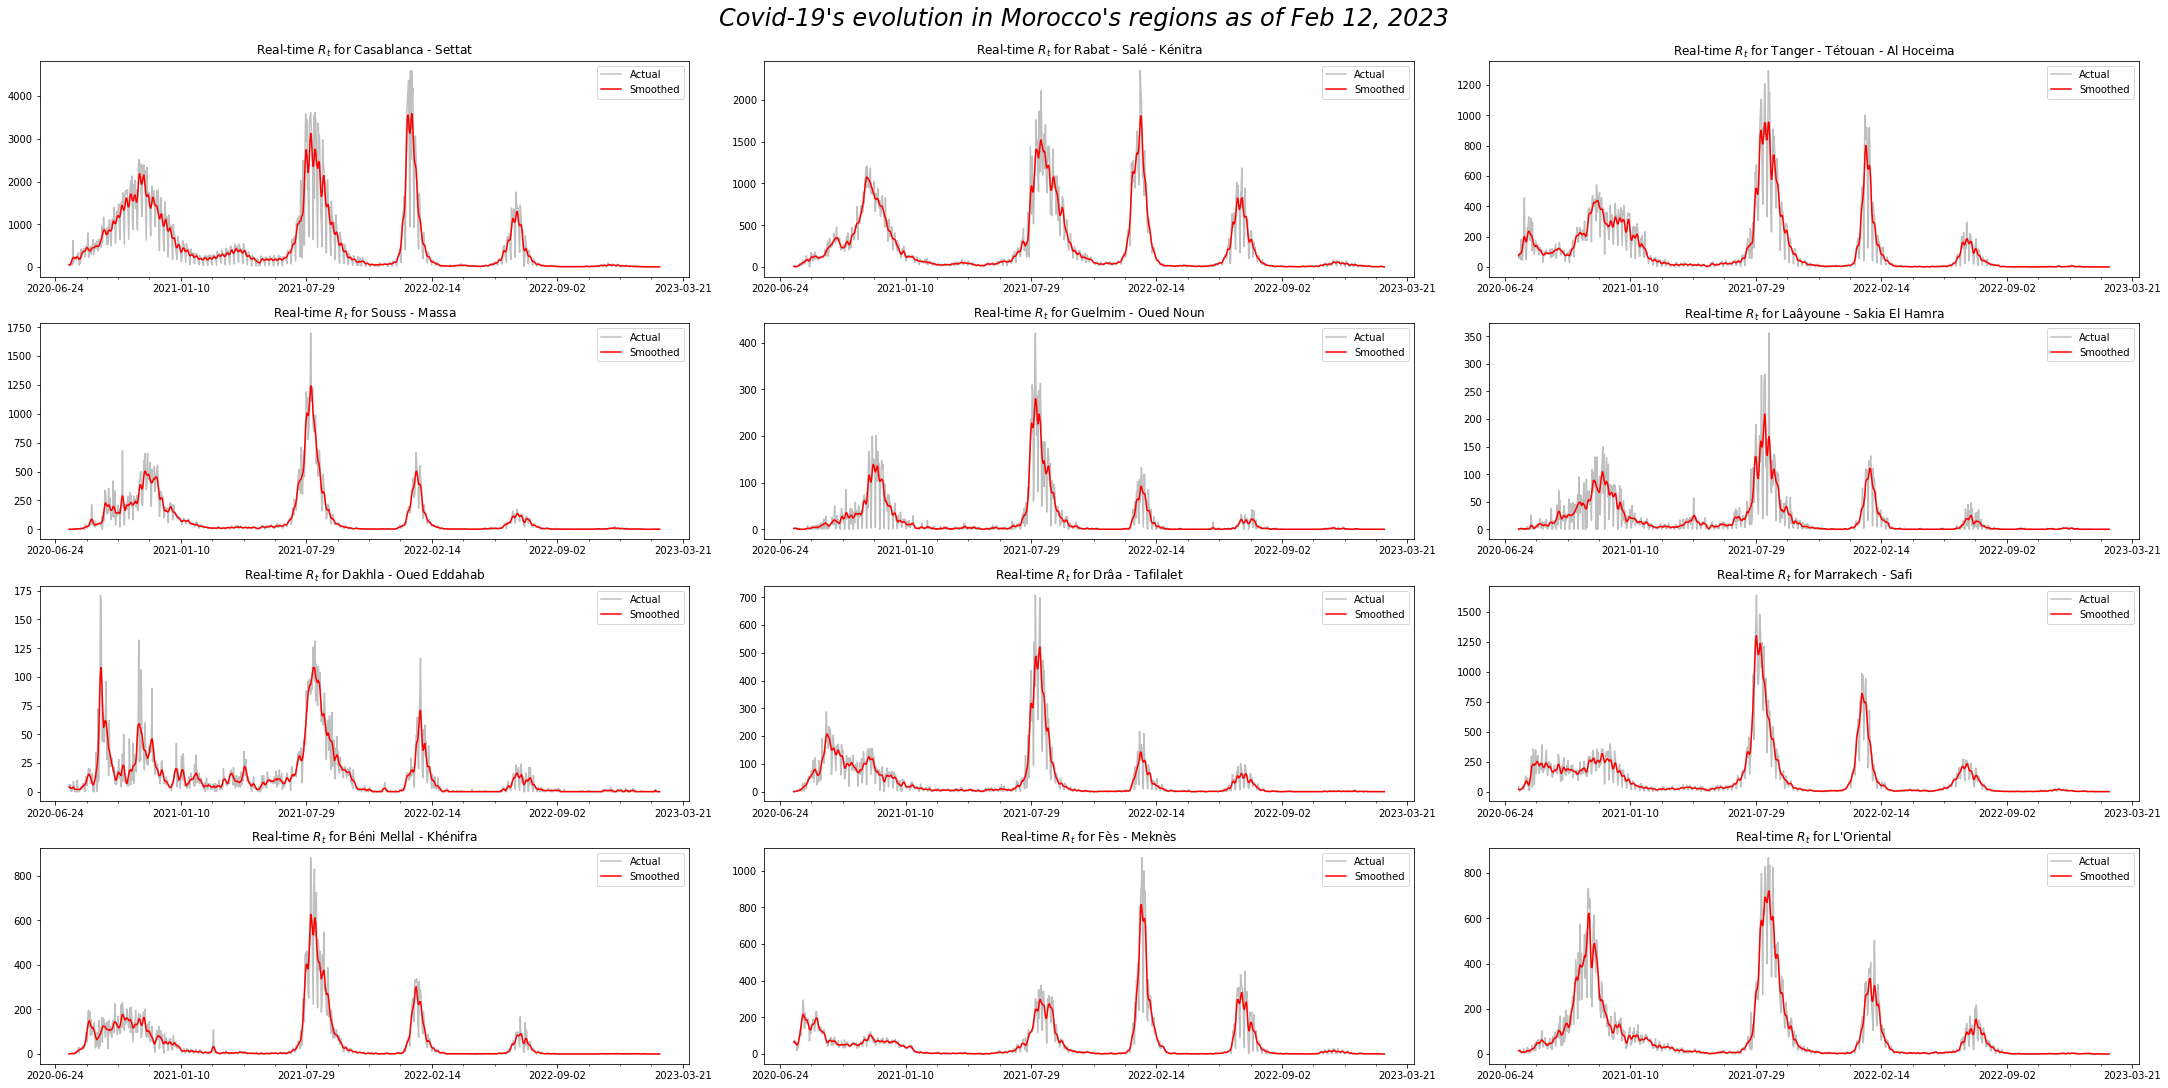

In [16]:
ncols = 3
nrows = 4

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15), constrained_layout=True)
axis = axis.flatten()

last_update_time = str(df_dates['dateFormatted'].iloc[-1].strftime('%b')) + " " + str(df_dates['dateFormatted'].iloc[-1].day) + ", " + str(df_dates['dateFormatted'].iloc[-1].year)

i = 0
original_plot = [] 
smoothed_plot = []

for ax_plot in axis:
    
    reg_d_plot  = pd.DataFrame(reg_data[i], df_dates['dateFormatted'])
    reg_d_plot = reg_d_plot.squeeze()

    cases_plot = reg_d_plot

    original_plot , smoothed_plot  = prepare_cases(cases_plot)

    ax_plot.plot(original_plot, label='Actual', c='k', zorder=1, alpha=.25)

    ax_plot.plot(smoothed_plot, label='Smoothed', color ='red')

    ax_plot.set_title(f'Real-time $R_t$ for {reg_list[i]}')
    ax_plot.legend()

    ax_plot.get_figure().set_facecolor('w')
    ax_plot.xaxis.set_major_locator(ticker.AutoLocator())
    ax_plot.xaxis.set_minor_locator(ticker.AutoMinorLocator())

    i += 1

fig.suptitle(f"Covid-19's evolution in Morocco's regions as of " + str(last_update_time), fontsize=24, fontstyle='italic')
fig.set_facecolor('w')

##Calculating the posterior values

In [17]:
def get_posteriors(sr, sigma=0.15):

    k = np.array([20, 40, 55, 90])

    R_T_MAX = 12
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
    GAMMA = 1/7
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    process_matrix /= process_matrix.sum(axis=0)
    
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    log_likelihood = 0.0

    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        current_prior = process_matrix @ posteriors[previous_day]
        numerator = likelihoods[current_day] * current_prior
        denominator = np.sum(numerator)
        posteriors[current_day] = numerator/denominator
        log_likelihood += np.log(denominator)
    return posteriors, log_likelihood

posteriors, log_likelihood = get_posteriors(smoothed[:50], sigma=.3)

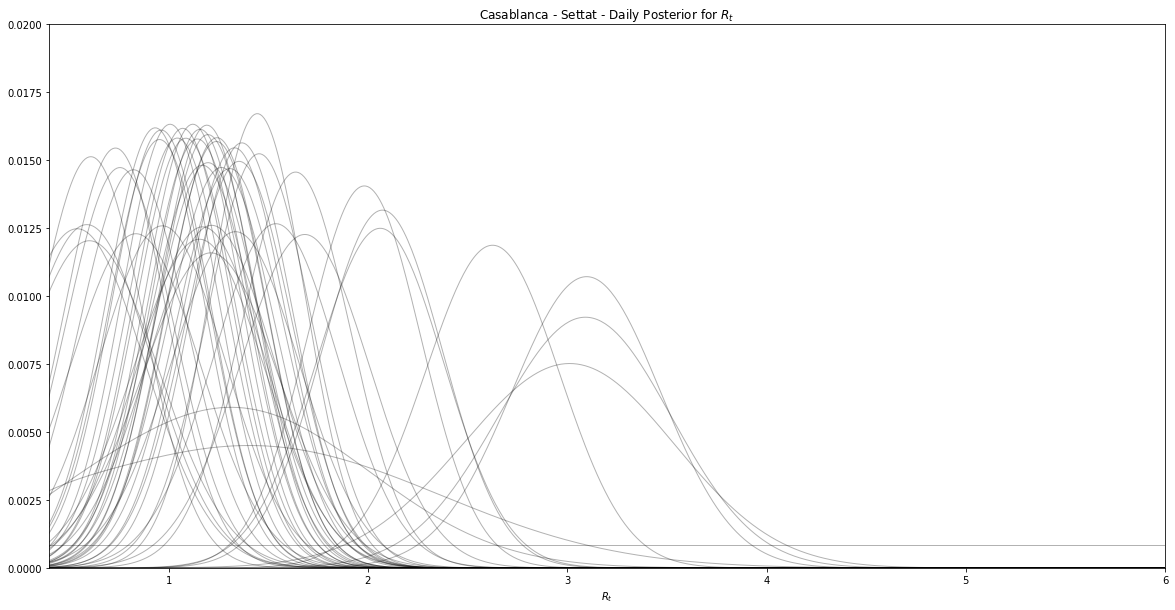

In [18]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6),
           ylim=(0,0.02), 
           figsize=(20, 10))

ax.set_xlabel('$R_t$');

In [19]:
hdis = highest_density_interval(posteriors, p=.8)

most_likely = posteriors.idxmax().rename('ML')

res_stat = pd.concat([most_likely, hdis], axis=1)

res_stat.head()

,ML,Low_80,High_80
0,0.00,0.00,9.61
1,1.40,0.29,2.40
2,1.31,0.41,2.08
3,3.01,2.31,3.67
4,3.09,2.51,3.62


##Plotting the real-time $R_t$ of a single region

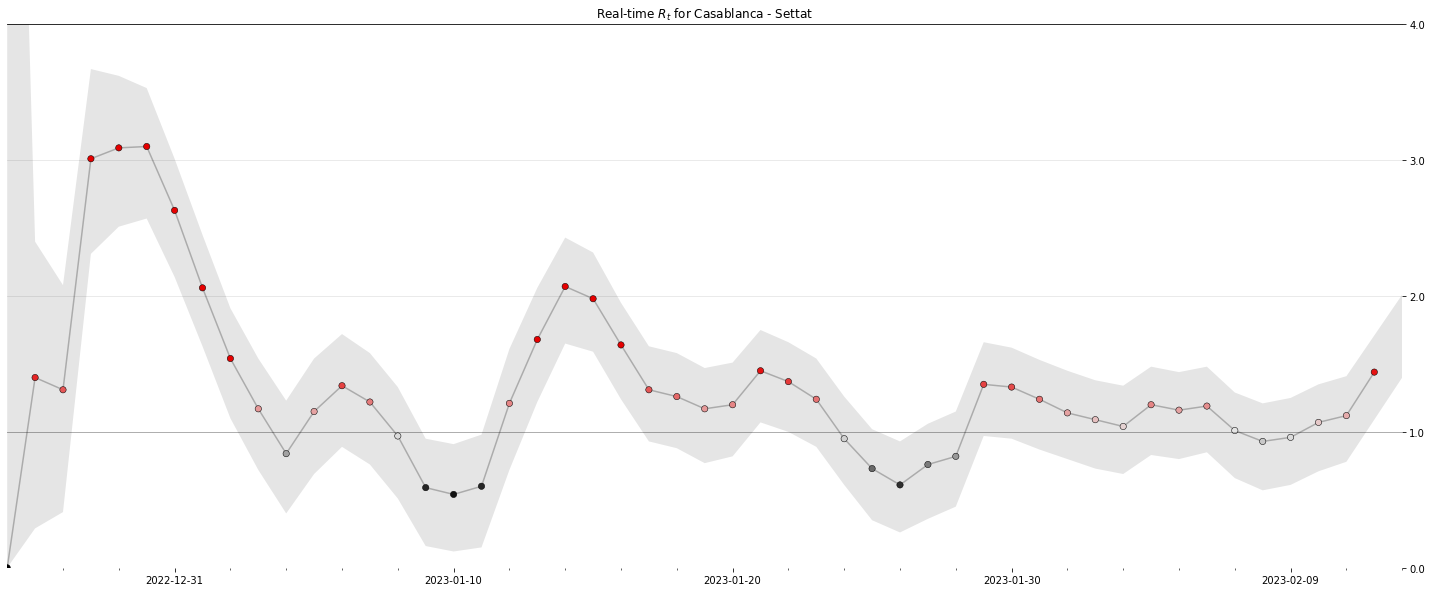

In [20]:
def plot_rt(result, ax, state_name):
        
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = df_dates['dateFormatted'].iloc[(len(df_dates['dateFormatted']) - len(res_stat['ML'].values)) :  len(df_dates['dateFormatted']) ]
    values = result['ML'].values
    
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    lowfn = interp1d(date2num(index),
                     result['Low_80'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_80'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp(index.iloc[0]), end=pd.Timestamp(index.iloc[-1]) + pd.Timedelta(days=1))

    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k',alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.set_ylim(0, 4.0)
    ax.set_xlim(pd.Timestamp(index.iloc[0]), pd.Timestamp(index.iloc[-1]) + pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(25, 10))

plot_rt(res_stat, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

##Calculating the log likelihoods of each region

In [21]:
sigmas = np.linspace(1/20, 1, 20)

results = {}

for i in range(12) :

    print(reg_list[i])    

    reg_d = pd.DataFrame(reg_data[i])
    reg_d = reg_d.squeeze()

    new, smoothed = prepare_cases(reg_d, cutoff=10)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(reg_d, cutoff=2)
    
    res = {}
    
    res['posteriors'] = []
    
    res['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed[:50], sigma=sigma)
        res['posteriors'].append(posteriors)
        res['log_likelihoods'].append(log_likelihood)
    
    results[reg_list[i]] = res

print('Done.')

Casablanca - Settat
Rabat - Salé - Kénitra
Tanger - Tétouan - Al Hoceima
Souss - Massa
Guelmim - Oued Noun
Laâyoune - Sakia El Hamra
Dakhla - Oued Eddahab
Drâa - Tafilalet
Marrakech - Safi
Béni Mellal - Khénifra
Fès - Meknès
L'Oriental
Done.


##Finding the maximum likelihood value for all regions

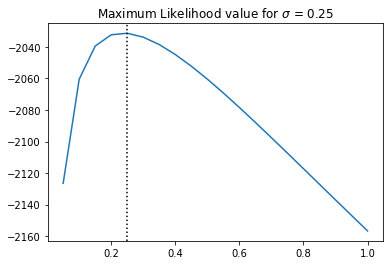

In [22]:
total_log_likelihoods = np.zeros_like(sigmas)

for state_name, result in results.items():

    if (len(result['log_likelihoods']) == 0 ) :
        continue
    if (float("-inf") in result['log_likelihoods'] ) :
        continue
    total_log_likelihoods += result['log_likelihoods']

max_likelihood_index = total_log_likelihoods.argmax()

sigma = sigmas[max_likelihood_index]

fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

##Re-calculating Real-time $R_t$ estimates with the best value of σ

In [23]:
final_results = None
plot_final = []
i = 0

for state_name, result in results.items():
      
      print(state_name, end="")

      posteriors = result['posteriors'][max_likelihood_index]
      
      try :

        hdis_80 = highest_density_interval(posteriors, p=.8)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        resultx = pd.concat([most_likely, hdis_80, hdis_50], axis=1)
        plot_final.append(resultx)

      except :
        print(" : error")
        continue

      if final_results is None:
          final_results = resultx
      else:
          final_results = pd.concat([final_results, resultx])
      
      print(" : " + str(len(plot_final[i])) + " values")
      
      i += 1


print('Done.')

Casablanca - Settat : 50 values
Rabat - Salé - Kénitra : 50 values
Tanger - Tétouan - Al Hoceima : 50 values
Souss - Massa : 50 values
Guelmim - Oued Noun : 50 values
Laâyoune - Sakia El Hamra : 50 values
Dakhla - Oued Eddahab : 50 values
Drâa - Tafilalet : 50 values
Marrakech - Safi : 50 values
Béni Mellal - Khénifra : 50 values
Fès - Meknès : 50 values
L'Oriental : 50 values
Done.


In [24]:
final_results.head()

,ML,Low_80,High_80,Low_50,High_50
0,0.00,0.00,9.61,0.00,6.01
1,1.41,0.25,2.37,0.72,1.90
2,1.32,0.39,2.06,0.82,1.72
3,2.95,2.21,3.55,2.51,3.22
4,3.05,2.48,3.56,2.72,3.29


In [25]:
final_results.to_csv("results.csv")

##Plotting the final results

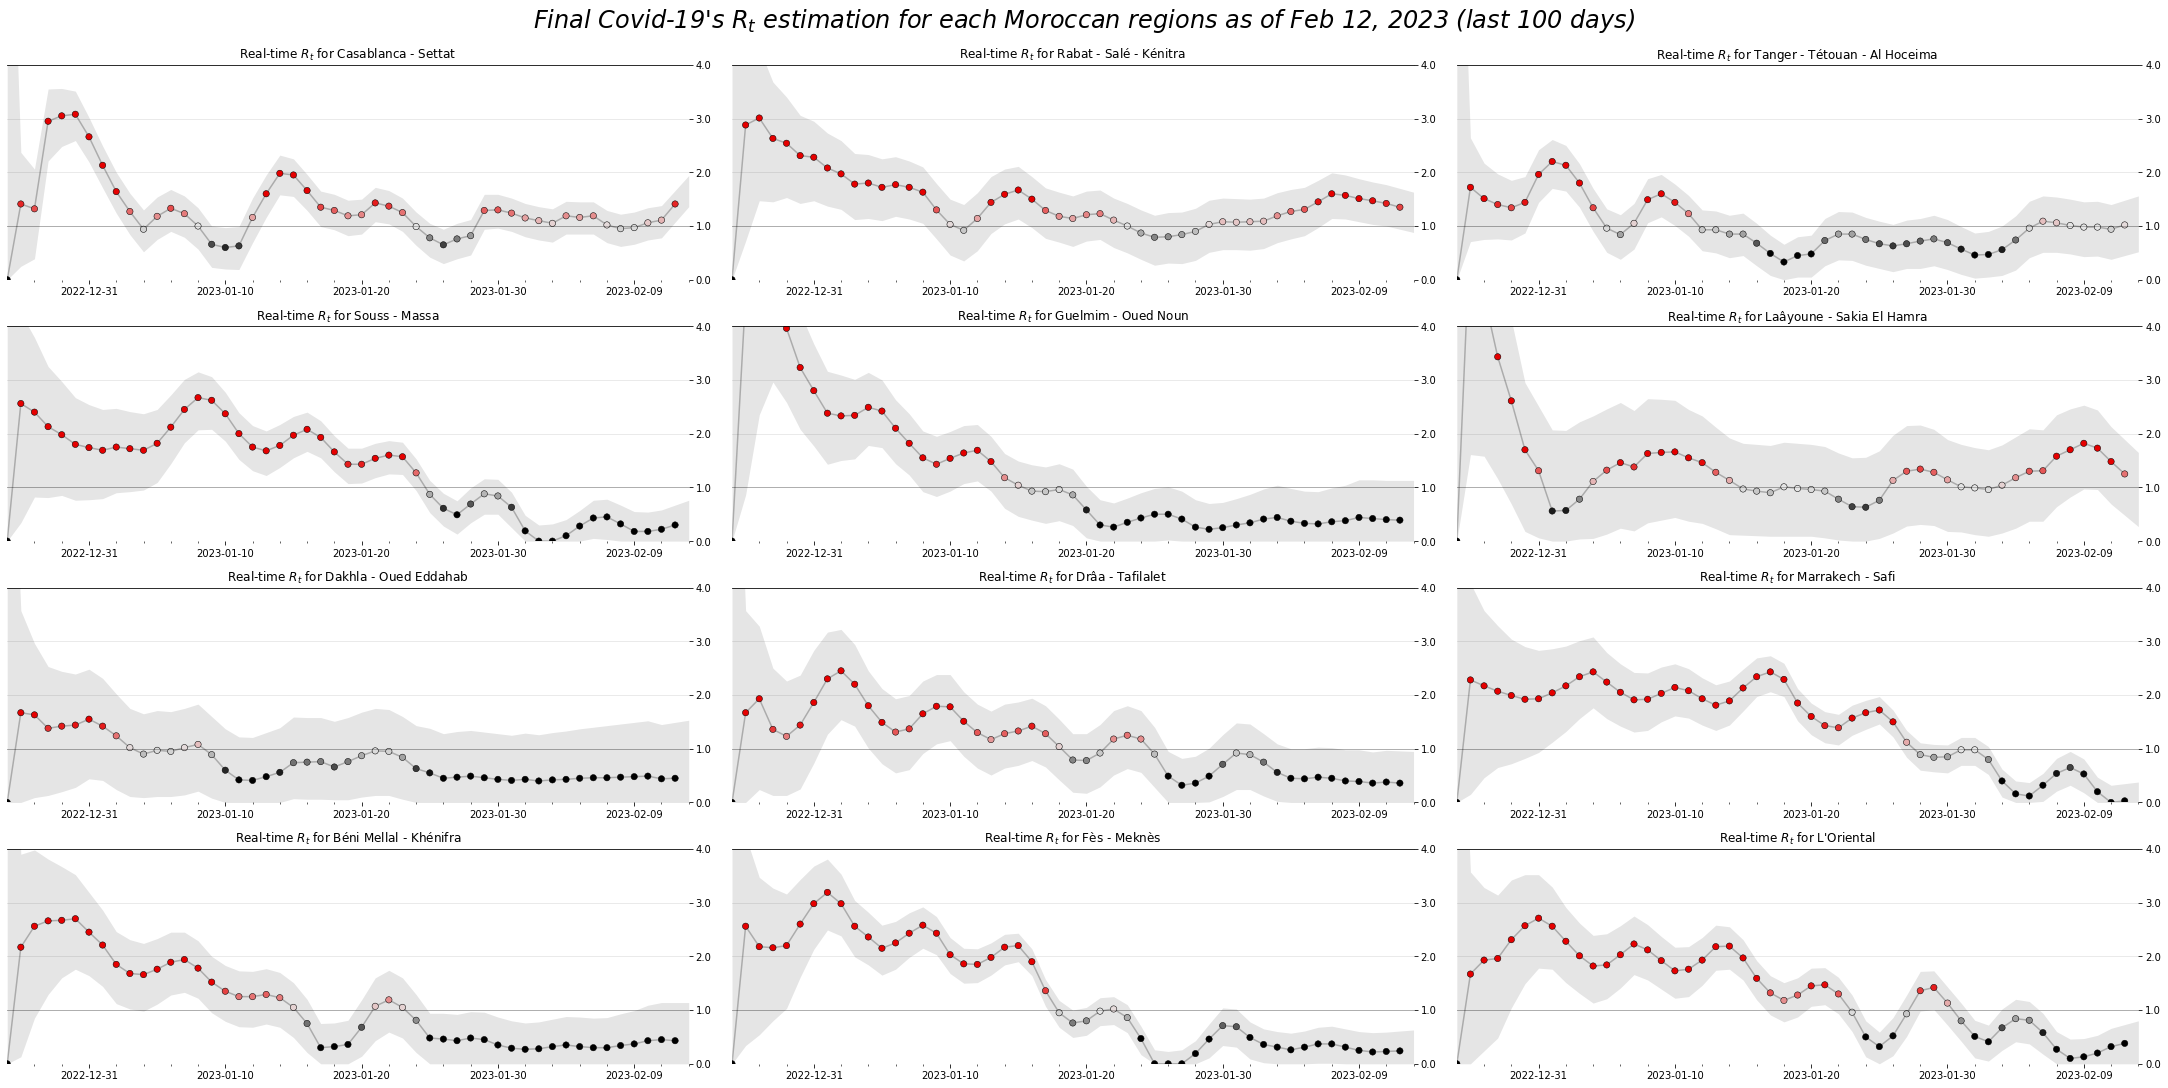

In [26]:
ncols = 3
nrows = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15), constrained_layout=True)
axes = axes.flatten()

data_last_update_datetime = str(df_dates['dateFormatted'].iloc[-1].strftime('%b')) + " " + str(df_dates['dateFormatted'].iloc[-1].day) + ", " + str(df_dates['dateFormatted'].iloc[-1].year)

i = 0

for axis in axes:

    if (i == 12) :
        break

    plot_rt(plot_final[i], axis, reg_list[i])

    axis.set_title(f'Real-time $R_t$ for {reg_list[i]}')
    axis.xaxis.set_major_locator(ticker.AutoLocator())
    axis.xaxis.set_minor_locator(ticker.AutoMinorLocator())

    i += 1

fig.suptitle(f"Final Covid-19's $R_t$ estimation for each Moroccan regions as of " + data_last_update_datetime + " (last 100 days)", fontsize=24, fontstyle='italic')
fig.set_facecolor('w')